In [1]:
# Installing the latest stable-baselines3 library.
# !pip install stable-baselines3
!pip install stable-baselines3
# Ignoring the restart runtime instruction and continue with the cell execution.

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 170 kB 5.4 MB/s 
     |████████████████████████████████| 1.5 MB 51.5 MB/s 
  Created wheel for gym: filename=gym-0.21.0-py3-none-any.whl size=1616827 sha256=f74b5082da5ffc94dd02df6c48eddcb765b5e82e0e5b7be480ac14f5dc8dacbd
  Stored in directory: /root/.cache/pip/wheels/76/ee/9c/36bfe3e079df99acf5ae57f4e3464ff2771b34447d6d2f2148
Successfully built gym
  Attempting uninstall: gym
    Found existing installation: gym 0.25.2
    Uninstalling gym-0.25.2:
      Successfully uninstalled gym-0.25.2


In [2]:
# Installing additional stable-baselines3 packages for plotting the agent learning outputs.
# !pip install stable-baselines3
!pip install stable-baselines3[extra]
!apt install swig cmake
!pip install stable-baselines3[extra] box2d box2d-kengz
# Ignoring the restart runtime instruction and continue with the cell execution.

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.6 MB 5.4 MB/s 
     |████████████████████████████████| 237 kB 65.7 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 51 kB 3.6 MB/s 
  Created wheel for AutoROM.accept-rom-license: filename=AutoROM.accept_rom_license-0.4.2-py3-none-any.whl size=441027 sha256=64602230a10098d67e8974d75209de569845fb68a8c9e9c656d6a8bfc844c9cc
  Stored in directory: /root/.cache/pip/wheels/87/67/2e/6147e7912fe37f5408b80d07527dab807c1d25f5c403a9538a
Successfully built AutoROM.accept-rom-license
Reading package lists... Done
Building dependency tree       
Reading state information... Done
cmake is already the newest version (3.10.2-1ubuntu2.18.04.2).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
U

In [3]:
# OpenAI gym related import statements.
# Building a simpler environment that works with stablebaselines.
import os
import gym
from gym import spaces
import numpy as np
import random

In [4]:
# Learning curve plotting realted package imports.
from gym.envs.registration import EnvSpec
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.results_plotter import load_results, ts2xy
from stable_baselines3.common.callbacks import BaseCallback

In [5]:
# import statements for 3D function plotting with matplotlib
from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np

In [6]:
# Utility class for saving the best model function.
class SaveOnBestTrainingRewardCallback(BaseCallback):
    """
    Callback for saving a model (the check is done every ``check_freq`` steps)
    based on the training reward (in practice, we recommend using ``EvalCallback``).

    :param check_freq: (int)
    :param log_dir: (str) Path to the folder where the model will be saved.
      It must contains the file created by the ``Monitor`` wrapper.
    :param verbose: (int)
    """
    def __init__(self, check_freq: int, log_dir: str, verbose=1):
        super(SaveOnBestTrainingRewardCallback, self).__init__(verbose)
        self.check_freq = check_freq
        self.log_dir = log_dir
        self.save_path = os.path.join(log_dir, 'best_model')
        self.best_mean_reward = -np.inf

    def _init_callback(self) -> None:
        # Create folder if needed
        if self.save_path is not None:
            os.makedirs(self.save_path, exist_ok=True)

    def _on_step(self) -> bool:
        if self.n_calls % self.check_freq == 0:
          # Retrieve training reward
          x, y = ts2xy(load_results(self.log_dir), 'timesteps')
          if len(x) > 0:
              # Mean training reward over the last 100 episodes
              mean_reward = np.mean(y[-100:])
              if self.verbose > 0:
                print(f"Num timesteps: {self.num_timesteps}")
                print(f"Best mean reward: {self.best_mean_reward:.2f} - Last mean reward per episode: {mean_reward:.2f}")
              # New best model, you could save the agent here
              if mean_reward > self.best_mean_reward:
                  self.best_mean_reward = mean_reward
                  # Example for saving best model
                  if self.verbose > 0:
                    print(f"Saving new best model to {self.save_path}.zip")
                  self.model.save(self.save_path)
        return True

# Create log dir for the agent monitoring and result plotting.
log_dir = "/tmp/gym/"
os.makedirs(log_dir, exist_ok=True)

In [7]:
# Note: The 3x3 road network environment doesn't rotate in its simple
# setting implementation.
# Implementation of the Simple 3x3 road network for MultiAgent RL.
class SizeThreeSimpleGridRoadEnv(gym.Env):
    # Defining the Driving Agent with name and gas values plus package flag.
    class DriverAgent():
        def __init__(self, name, gas, package, picked):
            self.name = name
            self.gas = gas
            self.package = package
            self.picked = picked # flag, package has been picked once by the agent.

    def __init__(self):
        # super(SizeThreeSimpleGridRoadEnv, self).__init__()
        # Defining different possible world configurations.
        self.world_one = np.array([[1, 0, 0],
                      [3, 0, 2],
                      [0, 0, 4]])
        # self.world_two = np.rot90(self.world_one)
        # self.world_three = np.rot90(self.world_two)
        # self.world_four = np.rot90(self.world_three)
        # Even the initial world configuration is defined to be different upon
        # environment instantiation. 
        # prob = random.uniform(0, 1)
        # Default value assignment below.
        self.world = self.world_one
        # if prob > 0.25 and prob <= 0.25:
        #     self.world = self.world_two
        # elif prob > 0.5 and prob <= 0.75:
        #     self.world = self.world_three
        # elif prob > 0.75 and prob <= 1:
        #     self.world = self.world_four
        self.world_start = self.world # This 'world_start', if reset() is called, never gets used.
        # Adding five actions for the environment.
        # 0: up, 1: right, 2: down, 3: left,; 4: stay/pass chance, 5: drop -> for agent learning simplicity eliminating 4 & 5 actions
        # When agent reaches at package location it automatically picks up the package.
        self.action_space = spaces.Discrete(4)
        shape_0 = np.size(self.world_start, 0)
        shape_1 = np.size(self.world_start, 1)
        self.observation_space = spaces.Box(low=0,
                                            high=4,
                                            shape=(shape_0 + 1, shape_1),
                                            dtype=np.int16)
        self.reward_range = (-10, 10)
        self.current_episode = 0
        self.success_episode = []
        # Defining the driver agents in the environment.
        self.agent_one = self.DriverAgent(1,3,0,False) # 3 integer value, when carrying package.
        self.agent_two = self.DriverAgent(2,8,0,False) # 3 integer value, when carrying package.
        self.spec = EnvSpec("SizeThreeSimpleGridRoadEnv-v0")

    def reset(self):
        # Game like formulation, each player agent moves one step at a time.
        self.agent_one = self.DriverAgent(1,3,0,False) # Instantiating agent 1 again.
        self.agent_two = self.DriverAgent(2,8,0,False) # Instantiating agent 2 again.
        self.current_player = self.agent_one
        # 'P' means the game is playable, 'W' means delivered, 'L' means no delivery.
        self.state = 'P'
        self.current_step = 0
        self.max_step = 32 # agent can choose not move as an alternate choice.
        # Selecting a world at random to function with.
        # Even the initial world configuration should be different.
        # prob = random.uniform(0, 1)
        # if prob > 0.25 and prob <= 0.25:
        #     self.world_start = self.world_two
        # elif prob > 0.5 and prob <= 0.75:
        #     self.world_start = self.world_three
        # elif prob > 0.75 and prob <= 1:
        #     self.world_start = self.world_four
        # elif prob < 0.25:
        #     self.world_start = self.world_one
        self.world_start = self.world_one    
        self.world = np.copy(self.world_start) # The self.world can be different from intial world.
        # no exploration_prize and bonus_reward as per my design.
        return self._next_observation()
    
    def _next_observation(self):
        obs = self.world
        data_to_add = [0] * np.size(self.world, 1)
        data_to_add[0] = self.current_player.name # adding current player's label in the observation.
        obs = np.append(obs, [data_to_add], axis=0)
        # Observation Sample provided below for reference:
        # last row, represents 'data_to_add' vector.
        # array([[1, 0, 0],
        #         [3, 0, 2],
        #         [0, 0, 4],
        #         [1, 0, 0]])
        return obs

    def _take_action(self, action):
        # Agent's name is matched to the array entries for index identification.
        # 'current_player.name' should be updated alongside the array values.
        current_pos = np.where(self.world == self.current_player.name)
        # the current agent must have gas in it.
        if self.current_player.gas > 0:
            if action == 0:
                next_pos = (current_pos[0] - 1, current_pos[1]) # Agent moving upwards.

                if next_pos[0] >= 0 and int(self.world[next_pos]) == 0:
                    self.world[next_pos] = self.current_player.name
                    self.world[current_pos] = 0
                    # Reducing the agent's gas by 1.
                    self.current_player.gas = self.current_player.gas - 1

                elif next_pos[0] >= 0 and int(self.world[next_pos]) in (1, 2):
                    pass # Two Agents can't be at the same place.

                elif next_pos[0] >= 0 and int(self.world[next_pos] == 3):
                    self.world[next_pos] = self.current_player.name
                    self.current_player.package = 3 # package is also hidden now from other agent.
                    self.current_player.picked = True # package is picked once by the agent.
                    self.world[current_pos] = 0
                    # Reducing the agent's gas by 1.
                    self.current_player.gas = self.current_player.gas - 1

                elif next_pos[0] >= 0 and int(self.world[next_pos] == 4):
                    # player should only be allowed this transition to this position
                    # when it is having the package with it.
                    if self.current_player.package == 3:
                        self.world[next_pos] = self.current_player.name # like 34 are already there, for example.
                        self.world[current_pos] = 0
                        self.state = 'W' # and the episode, should end at that moment.
                        # Reducing the agent's gas by 1.
                        self.current_player.gas = self.current_player.gas - 1
                    else:
                        pass


            elif action == 1:
                next_pos = (current_pos[0], current_pos[1] + 1)
                limit = np.size(self.world, 1)

                if next_pos[1] < limit and int(self.world[next_pos]) == 0:
                    self.world[next_pos] = self.current_player.name
                    self.world[current_pos] = 0
                    # Reducing the agent's gas by 1.
                    self.current_player.gas = self.current_player.gas - 1

                elif next_pos[1] < limit and int(self.world[next_pos]) in (1, 2):
                    pass # Two Agents can't be at the same place.

                elif next_pos[1] < limit and (int(self.world[next_pos]) == 3):
                    self.world[next_pos] = self.current_player.name
                    self.current_player.package = 3 # package is also hidden now from other agent.
                    self.current_player.picked = True # package is picked once by the agent.
                    self.world[current_pos] = 0
                    # Reducing the agent's gas by 1.
                    self.current_player.gas = self.current_player.gas - 1

                elif next_pos[1] < limit and int(self.world[next_pos] == 4):
                    # player should only be allowed this transition to this position
                    # when it is having the package with it.
                    if self.current_player.package == 3:
                        self.world[next_pos] = self.current_player.name # like 34 are already there, for example.
                        self.world[current_pos] = 0
                        self.state = 'W' # and the episode, should end at that moment.
                        # Reducing the agent's gas by 1.
                        self.current_player.gas = self.current_player.gas - 1
                    else:
                        pass


            elif action == 2:
                next_pos = (current_pos[0] + 1, current_pos[1])
                limit = np.size(self.world, 0)

                if next_pos[0] < limit and int(self.world[next_pos]) == 0:
                    self.world[next_pos] = self.current_player.name
                    self.world[current_pos] = 0
                    # Reducing the agent's gas by 1.
                    self.current_player.gas = self.current_player.gas - 1

                elif next_pos[0] < limit and int(self.world[next_pos]) in (1, 2):
                    pass # Two Agents can't be at the same place.

                elif next_pos[0] < limit and (int(self.world[next_pos]) == 3):
                    self.world[next_pos] = self.current_player.name
                    self.current_player.package = 3 # package is also hidden now from other agent.
                    self.current_player.picked = True # package is picked once by the agent.
                    self.world[current_pos] = 0
                    # Reducing the agent's gas by 1.
                    self.current_player.gas = self.current_player.gas - 1

                elif next_pos[0] < limit and int(self.world[next_pos] == 4):
                    # player should only be allowed this transition to this position
                    # when it is having the package with it.
                    if self.current_player.package == 3:
                        self.world[next_pos] = self.current_player.name # like 34 are already there, for example.
                        self.world[current_pos] = 0
                        self.state = 'W' # and the episode, should end at that moment.
                        # Reducing the agent's gas by 1.
                        self.current_player.gas = self.current_player.gas - 1
                    else:
                        pass

            elif action == 3:
                next_pos = (current_pos[0], current_pos[1] - 1)

                if next_pos[1] >= 0 and int(self.world[next_pos]) == 0:
                    self.world[next_pos] = self.current_player.name
                    self.world[current_pos] = 0
                    # Reducing the agent's gas by 1.
                    self.current_player.gas = self.current_player.gas - 1

                elif next_pos[1] >= 0 and int(self.world[next_pos]) in (1, 2):
                    pass # Two Agents can't be at the same place.

                elif next_pos[1] >= 0 and (int(self.world[next_pos]) == 3):
                    self.world[next_pos] = self.current_player.name
                    self.current_player.package = 3 # package is also hidden now from other agent.
                    self.current_player.picked = True # package is picked once by the agent.
                    self.world[current_pos] = 0
                    # Reducing the agent's gas by 1.
                    self.current_player.gas = self.current_player.gas - 1

                elif next_pos[1] >= 0 and int(self.world[next_pos] == 4):
                    # player should only be allowed this transition to this position
                    # when it is having the package with it.
                    if self.current_player.package == 3:
                        self.world[next_pos] = self.current_player.name # like 34 are already there, for example.
                        self.world[current_pos] = 0
                        self.state = 'W' # and the episode, should end at that moment.
                        # Reducing the agent's gas by 1.
                        self.current_player.gas = self.current_player.gas - 1
                    else:
                        pass

            # removing functionality for action 4 and 5 for environment simplicity.
            # Newly added logic based on three new possible actions.
            # elif action == 4 and self.current_player.name != 1: # passing is allowed for agent 2 only.
            #     pass # Corresponding agent selects to not move at their chance.
            
            # elif action == 5: # If agent is over the package, it has to pick it up, environment cases encoded above.
            #     # Agent can choose to drop the package, if it is loaded with it.
            #     # After, dropping the package the agent should dissappear.
            #     if self.current_player.package == 3:
            #         if self.world[current_pos] == 0:
            #             self.world[current_pos] = 3
            #             # agent dissappears from the grid after this drop.
            #         elif self.world[current_pos] == 4: # Added as extra case, functionally possibly won't be triggered.
            #             self.world[current_pos] = self.current_player.name
            #             self.state = 'W'
            
        else:
            # Player 1's gas is supposed to go empty first.
            # Therefore, upon having empty gas tank player should be allowed to
            # drop the package in the environment and disappear from the location.
            if self.current_player.package == 3:
                self.world[current_pos] = self.current_player.package
                # self.current_player.picked = False # package is dropped by the agent.
                # agent dissappears from the grid after this drop.
            else:
                self.world[current_pos] = 0 # If gas is finished, agent should dissappear.

        # If gas is empty for both agents, the episode should stop at that instant.
        if self.agent_one.gas == 0 and self.agent_two.gas == 0:
            self.state = 'L'


    def step(self, action):
        self._take_action(action)
        self.current_step += 1
        # Uncomment the below statement out, while debugging.
        # print(self.world) 

        if self.state == "W":
            reward = 2.5
            done = True
        elif self.state == 'L':
            reward = 0
            done = True
        elif self.state == 'P':
            reward = 0 # sparse reward encoding, only rewarded when episode ends.
            done = False

        if self.current_step >= self.max_step:
            print(f'New episode number {self.current_episode + 1}')
            done = True
        
        # removing functionality for alternate play for environment simplicity.
        # agents object used to identify agent properties.
        if self.current_player.name == 1: # and self.current_step > 6: # general condition > (2*gas)
            self.current_player = self.agent_two
        elif self.current_player.name == 2:
            self.current_player = self.agent_one

        # adding functionality of sequential agent interaction for environment simplicity.
        # if self.current_player.name == 1 and self.current_player.gas == 0:
        #     self.current_player = self.agent_two

        if done:
            self.render_episode(self.state)
            # self.reset()
            self.current_episode += 1
        
        # if done == True and self.state == 'L':
        #     self.reset()

        obs = self._next_observation()

        return obs, reward, done, {'state': self.state}, self.current_player

    def render_episode(self, win_or_lose):
        # Storing the rendered episodes in a file.
        self.success_episode.append(
            'Success' if win_or_lose == 'W' else 'Failure')
        file = open('render.txt', 'a')
        file.write('----------------------------\n')
        file.write(f'Episode number {self.current_episode}\n')
        file.write(
            f'{self.success_episode[-1]} in {self.current_step} steps\n')
        file.close()

In [ ]:
# Three more environment alternatives in this script.
# a. Size 3x3 random orientation 2D-grid environment.
# b. Size NxN simple orientation 2D-grid environment.
# c. Size NxN random orientation 2D-grid environment.

In [8]:
# Note: The 3x3 road network environment which rotate randomly in its simple
# setting implementation.
# Implementation of the Simple 3x3 road network for MultiAgent RL.
class SizeThreeGridRoadEnv(gym.Env):
    # Defining the Driving Agent with name and gas values plus package flag.
    class DriverAgent():
        def __init__(self, name, gas, package, picked):
            self.name = name
            self.gas = gas
            self.package = package
            self.picked = picked # flag, package has been picked once by the agent.

    def __init__(self):
        # super(SizeThreeSimpleGridRoadEnv, self).__init__()
        # Defining different possible world configurations.
        self.world_one = np.array([[1, 0, 0],
                      [3, 0, 2],
                      [0, 0, 4]])
        self.world_two = np.rot90(self.world_one)
        self.world_three = np.rot90(self.world_two)
        self.world_four = np.rot90(self.world_three)
        # Even the initial world configuration is defined to be different upon
        # environment instantiation. 
        prob = random.uniform(0, 1)
        # Default value assignment below.
        self.world = self.world_one
        if prob > 0.25 and prob <= 0.25:
            self.world = self.world_two
        elif prob > 0.5 and prob <= 0.75:
            self.world = self.world_three
        elif prob > 0.75 and prob <= 1:
            self.world = self.world_four
        self.world_start = self.world # This 'world_start', if reset() is called, never gets used.
        # Adding five actions for the environment.
        # 0: up, 1: right, 2: down, 3: left,; 4: stay/pass chance, 5: drop -> for agent learning simplicity eliminating 4 & 5 actions
        # When agent reaches at package location it automatically picks up the package.
        self.action_space = spaces.Discrete(4)
        shape_0 = np.size(self.world_start, 0)
        shape_1 = np.size(self.world_start, 1)
        self.observation_space = spaces.Box(low=0,
                                            high=4,
                                            shape=(shape_0 + 1, shape_1),
                                            dtype=np.int16)
        self.reward_range = (-10, 10)
        self.current_episode = 0
        self.success_episode = []
        # Defining the driver agents in the environment.
        self.agent_one = self.DriverAgent(1,3,0,False) # 3 integer value, when carrying package.
        self.agent_two = self.DriverAgent(2,8,0,False) # 3 integer value, when carrying package.
        self.spec = EnvSpec("SizeThreeGridRoadEnv-v0")

    def reset(self):
        # Game like formulation, each player agent moves one step at a time.
        self.agent_one = self.DriverAgent(1,3,0,False) # Instantiating agent 1 again.
        self.agent_two = self.DriverAgent(2,8,0,False) # Instantiating agent 2 again.
        self.current_player = self.agent_one
        # 'P' means the game is playable, 'W' means delivered, 'L' means no delivery.
        self.state = 'P'
        self.current_step = 0
        self.max_step = 32 # agent can choose not move as an alternate choice.
        # Selecting a world at random to function with.
        # Even the initial world configuration should be different.
        prob = random.uniform(0, 1)
        if prob > 0.25 and prob <= 0.25:
            self.world_start = self.world_two
        elif prob > 0.5 and prob <= 0.75:
            self.world_start = self.world_three
        elif prob > 0.75 and prob <= 1:
            self.world_start = self.world_four
        elif prob < 0.25:
            self.world_start = self.world_one
        self.world_start = self.world_one
        self.world = np.copy(self.world_start) # The self.world can be different from intial world.
        # no exploration_prize and bonus_reward as per my design.
        return self._next_observation()
    
    def _next_observation(self):
        obs = self.world
        data_to_add = [0] * np.size(self.world, 1)
        data_to_add[0] = self.current_player.name # adding current player's label in the observation.
        obs = np.append(obs, [data_to_add], axis=0)
        # Observation Sample provided below for reference:
        # last row, represents 'data_to_add' vector.
        # array([[1, 0, 0],
        #         [3, 0, 2],
        #         [0, 0, 4],
        #         [1, 0, 0]])
        return obs

    def _take_action(self, action):
        # Agent's name is matched to the array entries for index identification.
        # 'current_player.name' should be updated alongside the array values.
        current_pos = np.where(self.world == self.current_player.name)
        # the current agent must have gas in it.
        if self.current_player.gas > 0:
            if action == 0:
                next_pos = (current_pos[0] - 1, current_pos[1]) # Agent moving upwards.

                if next_pos[0] >= 0 and int(self.world[next_pos]) == 0:
                    self.world[next_pos] = self.current_player.name
                    self.world[current_pos] = 0
                    # Reducing the agent's gas by 1.
                    self.current_player.gas = self.current_player.gas - 1

                elif next_pos[0] >= 0 and int(self.world[next_pos]) in (1, 2):
                    pass # Two Agents can't be at the same place.

                elif next_pos[0] >= 0 and int(self.world[next_pos] == 3):
                    self.world[next_pos] = self.current_player.name
                    self.current_player.package = 3 # package is also hidden now from other agent.
                    self.current_player.picked = True # package is picked once by the agent.
                    self.world[current_pos] = 0
                    # Reducing the agent's gas by 1.
                    self.current_player.gas = self.current_player.gas - 1

                elif next_pos[0] >= 0 and int(self.world[next_pos] == 4):
                    # player should only be allowed this transition to this position
                    # when it is having the package with it.
                    if self.current_player.package == 3:
                        self.world[next_pos] = self.current_player.name # like 34 are already there, for example.
                        self.world[current_pos] = 0
                        self.state = 'W' # and the episode, should end at that moment.
                        # Reducing the agent's gas by 1.
                        self.current_player.gas = self.current_player.gas - 1
                    else:
                        pass


            elif action == 1:
                next_pos = (current_pos[0], current_pos[1] + 1)
                limit = np.size(self.world, 1)

                if next_pos[1] < limit and int(self.world[next_pos]) == 0:
                    self.world[next_pos] = self.current_player.name
                    self.world[current_pos] = 0
                    # Reducing the agent's gas by 1.
                    self.current_player.gas = self.current_player.gas - 1

                elif next_pos[1] < limit and int(self.world[next_pos]) in (1, 2):
                    pass # Two Agents can't be at the same place.

                elif next_pos[1] < limit and (int(self.world[next_pos]) == 3):
                    self.world[next_pos] = self.current_player.name
                    self.current_player.package = 3 # package is also hidden now from other agent.
                    self.current_player.picked = True # package is picked once by the agent.
                    self.world[current_pos] = 0
                    # Reducing the agent's gas by 1.
                    self.current_player.gas = self.current_player.gas - 1

                elif next_pos[1] < limit and int(self.world[next_pos] == 4):
                    # player should only be allowed this transition to this position
                    # when it is having the package with it.
                    if self.current_player.package == 3:
                        self.world[next_pos] = self.current_player.name # like 34 are already there, for example.
                        self.world[current_pos] = 0
                        self.state = 'W' # and the episode, should end at that moment.
                        # Reducing the agent's gas by 1.
                        self.current_player.gas = self.current_player.gas - 1
                    else:
                        pass


            elif action == 2:
                next_pos = (current_pos[0] + 1, current_pos[1])
                limit = np.size(self.world, 0)

                if next_pos[0] < limit and int(self.world[next_pos]) == 0:
                    self.world[next_pos] = self.current_player.name
                    self.world[current_pos] = 0
                    # Reducing the agent's gas by 1.
                    self.current_player.gas = self.current_player.gas - 1

                elif next_pos[0] < limit and int(self.world[next_pos]) in (1, 2):
                    pass # Two Agents can't be at the same place.

                elif next_pos[0] < limit and (int(self.world[next_pos]) == 3):
                    self.world[next_pos] = self.current_player.name
                    self.current_player.package = 3 # package is also hidden now from other agent.
                    self.current_player.picked = True # package is picked once by the agent.
                    self.world[current_pos] = 0
                    # Reducing the agent's gas by 1.
                    self.current_player.gas = self.current_player.gas - 1

                elif next_pos[0] < limit and int(self.world[next_pos] == 4):
                    # player should only be allowed this transition to this position
                    # when it is having the package with it.
                    if self.current_player.package == 3:
                        self.world[next_pos] = self.current_player.name # like 34 are already there, for example.
                        self.world[current_pos] = 0
                        self.state = 'W' # and the episode, should end at that moment.
                        # Reducing the agent's gas by 1.
                        self.current_player.gas = self.current_player.gas - 1
                    else:
                        pass

            elif action == 3:
                next_pos = (current_pos[0], current_pos[1] - 1)

                if next_pos[1] >= 0 and int(self.world[next_pos]) == 0:
                    self.world[next_pos] = self.current_player.name
                    self.world[current_pos] = 0
                    # Reducing the agent's gas by 1.
                    self.current_player.gas = self.current_player.gas - 1

                elif next_pos[1] >= 0 and int(self.world[next_pos]) in (1, 2):
                    pass # Two Agents can't be at the same place.

                elif next_pos[1] >= 0 and (int(self.world[next_pos]) == 3):
                    self.world[next_pos] = self.current_player.name
                    self.current_player.package = 3 # package is also hidden now from other agent.
                    self.current_player.picked = True # package is picked once by the agent.
                    self.world[current_pos] = 0
                    # Reducing the agent's gas by 1.
                    self.current_player.gas = self.current_player.gas - 1

                elif next_pos[1] >= 0 and int(self.world[next_pos] == 4):
                    # player should only be allowed this transition to this position
                    # when it is having the package with it.
                    if self.current_player.package == 3:
                        self.world[next_pos] = self.current_player.name # like 34 are already there, for example.
                        self.world[current_pos] = 0
                        self.state = 'W' # and the episode, should end at that moment.
                        # Reducing the agent's gas by 1.
                        self.current_player.gas = self.current_player.gas - 1
                    else:
                        pass

            # removing functionality for action 4 and 5 for environment simplicity.
            # Newly added logic based on three new possible actions.
            # elif action == 4 and self.current_player.name != 1: # passing is allowed for agent 2 only.
            #     pass # Corresponding agent selects to not move at their chance.
            
            # elif action == 5: # If agent is over the package, it has to pick it up, environment cases encoded above.
            #     # Agent can choose to drop the package, if it is loaded with it.
            #     # After, dropping the package the agent should dissappear.
            #     if self.current_player.package == 3:
            #         if self.world[current_pos] == 0:
            #             self.world[current_pos] = 3
            #             # agent dissappears from the grid after this drop.
            #         elif self.world[current_pos] == 4: # Added as extra case, functionally possibly won't be triggered.
            #             self.world[current_pos] = self.current_player.name
            #             self.state = 'W'
            
        else:
            # Player 1's gas is supposed to go empty first.
            # Therefore, upon having empty gas tank player should be allowed to
            # drop the package in the environment and disappear from the location.
            if self.current_player.package == 3:
                self.world[current_pos] = self.current_player.package
                # self.current_player.picked = False # package is dropped by the agent.
                # agent dissappears from the grid after this drop.
            else:
                self.world[current_pos] = 0 # If gas is finished, agent should dissappear.

        # If gas is empty for both agents, the episode should stop at that instant.
        if self.agent_one.gas == 0 and self.agent_two.gas == 0:
            self.state = 'L'


    def step(self, action):
        self._take_action(action)
        self.current_step += 1
        # Uncomment the below statement out, while debugging.
        # print(self.world) 

        if self.state == "W":
            reward = 2.5
            done = True
        elif self.state == 'L':
            reward = 0
            done = True
        elif self.state == 'P':
            reward = 0 # sparse reward encoding, only rewarded when episode ends.
            done = False

        if self.current_step >= self.max_step:
            print(f'New episode number {self.current_episode + 1}')
            done = True
        
        # removing functionality for alternate play for environment simplicity.
        # agents object used to identify agent properties.
        if self.current_player.name == 1: #  and self.current_step > 6: # general condition > (2*gas)
            self.current_player = self.agent_two
        elif self.current_player.name == 2:
            self.current_player = self.agent_one

        # adding functionality of sequential agent interaction for environment simplicity.
        # if self.current_player.name == 1 and self.current_player.gas == 0:
        #     self.current_player = self.agent_two

        if done:
            self.render_episode(self.state)
            # self.reset()
            self.current_episode += 1
        
        # if done == True and self.state == 'L':
        #     self.reset()

        obs = self._next_observation()

        return obs, reward, done, {'state': self.state}, self.current_player

    def render_episode(self, win_or_lose):
        # Storing the rendered episodes in a file.
        self.success_episode.append(
            'Success' if win_or_lose == 'W' else 'Failure')
        file = open('render.txt', 'a')
        file.write('----------------------------\n')
        file.write(f'Episode number {self.current_episode}\n')
        file.write(
            f'{self.success_episode[-1]} in {self.current_step} steps\n')
        file.close()

In [7]:
# Note: The NxN road network environment doesn't rotate in its simple
# setting implementation.
# Implementation of the Simple NxN road network for MultiAgent RL.
class SimpleGridRoadEnv(gym.Env):
    # Defining the Driving Agent with name and gas values plus package flag.
    class DriverAgent():
        def __init__(self, name, gas, package):
            self.name = name
            self.gas = gas
            self.package = package

    def __init__(self, size=5, gas=7):
        # size: grid size, gas: values restricted between (n_min: trunc(n/2), n_max: 2*(n-1)-1)
        # converting even size to nearest odd number.
        self.size = size
        if size % 2 == 0:
            self.size = self.size+1
        # Defining different possible world configurations.
        self.world_one = np.zeros((self.size,self.size), dtype=int)
        # Setting up env values for the numpy array.
        self.world_one[0][0]=1
        self.world_one[self.size-1][self.size-1]=4
        self.world_one[self.size//2][self.size-1]=2
        self.world_one[self.size//2][0]=3
        self.world = self.world_one
        # if prob > 0.25 and prob <= 0.25:
        #     self.world = self.world_two
        # elif prob > 0.5 and prob <= 0.75:
        #     self.world = self.world_three
        # elif prob > 0.75 and prob <= 1:
        #     self.world = self.world_four
        self.world_start = self.world # This 'world_start', if reset() is called, never gets used.
        # Adding five actions for the environment.
        # 0: up, 1: right, 2: down, 3: left, 4: stay/pass chance, 5: drop & dissappear
        # When agent reaches at package location it automatically picks up the package.
        self.action_space = spaces.Discrete(4)
        shape_0 = np.size(self.world_start, 0)
        shape_1 = np.size(self.world_start, 1)
        self.observation_space = spaces.Box(low=0,
                                            high=4,
                                            shape=(shape_0 + 1, shape_1),
                                            dtype=np.int16)
        self.reward_range = (-10, 10)
        self.current_episode = 0
        self.success_episode = []
        # Defining the driver agents in the environment.
        self.gas = gas
        # truncating the gas to the desirable range for experimentation.
        if (self.gas < self.size//2) or (self.gas > (2*(self.size-1)-1)):
            self.gas = random.randint(self.size//2, 2*(self.size-1))
        self.agent_one = self.DriverAgent(1,self.gas,0) # 3 integer value, when carrying package.
        self.agent_two = self.DriverAgent(2,int(self.gas*3),0) # 3 integer value, when carrying package.
        self.spec = EnvSpec("SimpleGridRoadEnv-v0")

    def reset(self):
        # Game like formulation, each player agent moves one step at a time.
        self.agent_one = self.DriverAgent(1,self.gas,0) # Instantiating agent 1 again.
        self.agent_two = self.DriverAgent(2,int(self.gas*3),0) # Instantiating agent 2 again.
        self.current_player = self.agent_one
        # 'P' means the game is playable, 'W' means delivered, 'L' means no delivery.
        self.state = 'P'
        self.current_step = 0
        self.max_step = int(self.gas*5) # agent can choose not move as an alternate choice.
        # Selecting a world at random to function with.
        # Even the initial world configuration should be different.
        # prob = random.uniform(0, 1)
        # if prob > 0.25 and prob <= 0.25:
        #     self.world_start = self.world_two
        # elif prob > 0.5 and prob <= 0.75:
        #     self.world_start = self.world_three
        # elif prob > 0.75 and prob <= 1:
        #     self.world_start = self.world_four
        # elif prob < 0.25:
        #     self.world_start = self.world_one
        self.world_start = self.world_one    
        self.world = np.copy(self.world_start) # The self.world can be different from intial world.
        # no exploration_prize and bonus_reward as per my design.
        return self._next_observation()
    
    def _next_observation(self):
        obs = self.world
        data_to_add = [0] * np.size(self.world, 1)
        data_to_add[0] = self.current_player.name # adding current player's label in the observation.
        obs = np.append(obs, [data_to_add], axis=0)
        # Observation Sample provided below for reference:
        # last row, represents 'data_to_add' vector.
        # A 3x3 observation grid example for reference.
        # array([[1, 0, 0],
        #         [3, 0, 2],
        #         [0, 0, 4],
        #         [1, 0, 0]])
        return obs

    def _take_action(self, action):
        # Agent's name is matched to the array entries for index identification.
        # 'current_player.name' should be updated alongside the array values.
        current_pos = np.where(self.world == self.current_player.name)
        # the current agent must have gas in it.
        if self.current_player.gas > 0:
            if action == 0:
                next_pos = (current_pos[0] - 1, current_pos[1]) # Agent moving upwards.

                if next_pos[0] >= 0 and int(self.world[next_pos]) == 0:
                    self.world[next_pos] = self.current_player.name
                    self.world[current_pos] = 0
                    # Reducing the agent's gas by 1.
                    self.current_player.gas = self.current_player.gas - 1

                elif next_pos[0] >= 0 and int(self.world[next_pos]) in (1, 2):
                    pass # Two Agents can't be at the same place.

                elif next_pos[0] >= 0 and int(self.world[next_pos] == 3):
                    self.world[next_pos] = self.current_player.name
                    self.current_player.package = 3 # package is also hidden now from other agent.
                    self.world[current_pos] = 0
                    # Reducing the agent's gas by 1.
                    self.current_player.gas = self.current_player.gas - 1

                elif next_pos[0] >= 0 and int(self.world[next_pos] == 4):
                    # player should only be allowed this transition to this position
                    # when it is having the package with it.
                    if self.current_player.package == 3:
                        self.world[next_pos] = self.current_player.name # like 34 are already there, for example.
                        self.world[current_pos] = 0
                        self.state = 'W' # and the episode, should end at that moment.
                        # Reducing the agent's gas by 1.
                        self.current_player.gas = self.current_player.gas - 1
                    else:
                        pass


            elif action == 1:
                next_pos = (current_pos[0], current_pos[1] + 1)
                limit = np.size(self.world, 1)

                if next_pos[1] < limit and int(self.world[next_pos]) == 0:
                    self.world[next_pos] = self.current_player.name
                    self.world[current_pos] = 0
                    # Reducing the agent's gas by 1.
                    self.current_player.gas = self.current_player.gas - 1

                elif next_pos[1] < limit and int(self.world[next_pos]) in (1, 2):
                    pass # Two Agents can't be at the same place.

                elif next_pos[1] < limit and (int(self.world[next_pos]) == 3):
                    self.world[next_pos] = self.current_player.name
                    self.current_player.package = 3 # package is also hidden now from other agent.
                    self.world[current_pos] = 0
                    # Reducing the agent's gas by 1.
                    self.current_player.gas = self.current_player.gas - 1

                elif next_pos[1] < limit and int(self.world[next_pos] == 4):
                    # player should only be allowed this transition to this position
                    # when it is having the package with it.
                    if self.current_player.package == 3:
                        self.world[next_pos] = self.current_player.name # like 34 are already there, for example.
                        self.world[current_pos] = 0
                        self.state = 'W' # and the episode, should end at that moment.
                        # Reducing the agent's gas by 1.
                        self.current_player.gas = self.current_player.gas - 1
                    else:
                        pass


            elif action == 2:
                next_pos = (current_pos[0] + 1, current_pos[1])
                limit = np.size(self.world, 0)

                if next_pos[0] < limit and int(self.world[next_pos]) == 0:
                    self.world[next_pos] = self.current_player.name
                    self.world[current_pos] = 0
                    # Reducing the agent's gas by 1.
                    self.current_player.gas = self.current_player.gas - 1

                elif next_pos[0] < limit and int(self.world[next_pos]) in (1, 2):
                    pass # Two Agents can't be at the same place.

                elif next_pos[0] < limit and (int(self.world[next_pos]) == 3):
                    self.world[next_pos] = self.current_player.name
                    self.current_player.package = 3 # package is also hidden now from other agent.
                    self.world[current_pos] = 0
                    # Reducing the agent's gas by 1.
                    self.current_player.gas = self.current_player.gas - 1

                elif next_pos[0] < limit and int(self.world[next_pos] == 4):
                    # player should only be allowed this transition to this position
                    # when it is having the package with it.
                    if self.current_player.package == 3:
                        self.world[next_pos] = self.current_player.name # like 34 are already there, for example.
                        self.world[current_pos] = 0
                        self.state = 'W' # and the episode, should end at that moment.
                        # Reducing the agent's gas by 1.
                        self.current_player.gas = self.current_player.gas - 1
                    else:
                        pass

            elif action == 3:
                next_pos = (current_pos[0], current_pos[1] - 1)

                if next_pos[1] >= 0 and int(self.world[next_pos]) == 0:
                    self.world[next_pos] = self.current_player.name
                    self.world[current_pos] = 0
                    # Reducing the agent's gas by 1.
                    self.current_player.gas = self.current_player.gas - 1

                elif next_pos[1] >= 0 and int(self.world[next_pos]) in (1, 2):
                    pass # Two Agents can't be at the same place.

                elif next_pos[1] >= 0 and (int(self.world[next_pos]) == 3):
                    self.world[next_pos] = self.current_player.name
                    self.current_player.package = 3 # package is also hidden now from other agent.
                    self.world[current_pos] = 0
                    # Reducing the agent's gas by 1.
                    self.current_player.gas = self.current_player.gas - 1

                elif next_pos[1] >= 0 and int(self.world[next_pos] == 4):
                    # player should only be allowed this transition to this position
                    # when it is having the package with it.
                    if self.current_player.package == 3:
                        self.world[next_pos] = self.current_player.name # like 34 are already there, for example.
                        self.world[current_pos] = 0
                        self.state = 'W' # and the episode, should end at that moment.
                        # Reducing the agent's gas by 1.
                        self.current_player.gas = self.current_player.gas - 1
                    else:
                        pass

            # Newly added logic based on three new possible actions.
            # elif action == 4 and self.current_player.name != 1: # passing is only allowed for agent 2.
            #     pass # Corresponding agent selects to not move at their chance.
            
            # elif action == 5: # If agent is over the package, it has to pick it up, environment cases encoded above.
            #     # Agent can choose to drop the package, if it is loaded with it.
            #     # After, dropping the package the agent should dissappear.
            #     if self.current_player.package == 3:
            #         if self.world[current_pos] == 0:
            #             self.world[current_pos] = 3
            #             # agent dissappears from the grid after this drop.
            #         elif self.world[current_pos] == 4: # Added as extra case, functionally possibly won't be triggered.
            #             self.world[current_pos] = self.current_player.name
            #             self.state = 'W'
            
        else:
            # Player 1's gas is supposed to go empty first.
            # Therefore, upon having empty gas tank player should be allowed to
            # drop the package in the environment and disappear from the location.
            if self.current_player.package == 3:
                self.world[current_pos] = self.current_player.package
                # agent dissappears from the grid after this drop.
            else:
                self.world[current_pos] = 0 # If gas is finished, agent should dissappear.
        # If gas is empty for both agents, the episode should stop at that instant.
        if self.agent_one.gas == 0 and self.agent_two.gas == 0:
            self.state = 'L'


    def step(self, action):
        self._take_action(action)
        self.current_step += 1
        # Uncomment the below statement out, while debugging.
        # print(self.world) 

        if self.state == "W":
            reward = 5.75
            done = True
        elif self.state == 'L':
            reward = 0
            done = True
        elif self.state == 'P':
            reward = 0 # sparse reward encoding, only rewarded when episode ends.
            done = False

        if self.current_step >= self.max_step:
            print(f'New episode number {self.current_episode + 1}')
            done = True

        # agents object used to identify agent properties.
        if self.current_player.name == 1: # and self.current_step > self.gas*2:
            self.current_player = self.agent_two
        elif self.current_player.name == 2:
            self.current_player = self.agent_one

        if done:
            self.render_episode(self.state)
            self.current_episode += 1

        obs = self._next_observation()

        return obs, reward, done, {'state': self.state}, self.current_player

    def render_episode(self, win_or_lose):
        # Storing the rendered episodes in a file.
        self.success_episode.append(
            'Success' if win_or_lose == 'W' else 'Failure')
        file = open('render.txt', 'a')
        file.write('----------------------------\n')
        file.write(f'Episode number {self.current_episode}\n')
        file.write(
            f'{self.success_episode[-1]} in {self.current_step} steps\n')
        file.close()

In [10]:
# Note: The NxN road network environment that rotates in its simple
# setting implementation.
# Implementation of the Simple NxN road network for MultiAgent RL.
class GridRoadEnv(gym.Env):
    # Defining the Driving Agent with name and gas values plus package flag.
    class DriverAgent():
        def __init__(self, name, gas, package):
            self.name = name
            self.gas = gas
            self.package = package

    def __init__(self, size=5, gas=7):
        # size: grid size, gas: values restricted between (n_min: trunc(n/2), n_max: 2*(n-1)-1)
        # converting even size to nearest odd number.
        self.size = size
        if size % 2 == 0:
            self.size = self.size+1
        # Defining different possible world configurations.
        self.world_one = np.zeros((self.size,self.size), dtype=int)
        # Setting up env values for the numpy array.
        self.world_one[0][0]=1
        self.world_one[self.size-1][self.size-1]=4
        self.world_one[self.size//2][self.size-1]=2
        self.world_one[self.size//2][0]=3
        self.world = self.world_one

        self.world_two = np.rot90(self.world_one)
        self.world_three = np.rot90(self.world_two)
        self.world_four = np.rot90(self.world_three)
        # Even the initial world configuration is defined to be different upon
        # environment instantiation. 
        prob = random.uniform(0, 1)
        # Default value assignment below.
        if prob > 0.25 and prob <= 0.25:
            self.world = self.world_two
        elif prob > 0.5 and prob <= 0.75:
            self.world = self.world_three
        elif prob > 0.75 and prob <= 1:
            self.world = self.world_four
        self.world_start = self.world # This 'world_start', if reset() is called, never gets used.
        # Adding five actions for the environment.
        # 0: up, 1: right, 2: down, 3: left, 4: stay/pass chance, 5: drop & dissappear
        # When agent reaches at package location it automatically picks up the package.
        self.action_space = spaces.Discrete(4)
        shape_0 = np.size(self.world_start, 0)
        shape_1 = np.size(self.world_start, 1)
        self.observation_space = spaces.Box(low=0,
                                            high=4,
                                            shape=(shape_0 + 1, shape_1),
                                            dtype=np.int16)
        self.reward_range = (-10, 10)
        self.current_episode = 0
        self.success_episode = []
        # Defining the driver agents in the environment.
        self.gas = gas
        # truncating the gas to the desirable range for experimentation.
        if (self.gas < self.size//2) or (self.gas > (2*(self.size-1)-1)):
            self.gas = random.randint(self.size//2, 2*(self.size-1))
        self.agent_one = self.DriverAgent(1,self.gas,0) # 3 integer value, when carrying package.
        self.agent_two = self.DriverAgent(2,int(self.gas*3),0) # 3 integer value, when carrying package.
        self.spec = EnvSpec("GridRoadEnv-v0")

    def reset(self):
        # Game like formulation, each player agent moves one step at a time.
        self.agent_one = self.DriverAgent(1,self.gas,0) # Instantiating agent 1 again.
        self.agent_two = self.DriverAgent(2,int(self.gas*3),0) # Instantiating agent 2 again.
        self.current_player = self.agent_one
        # 'P' means the game is playable, 'W' means delivered, 'L' means no delivery.
        self.state = 'P'
        self.current_step = 0
        self.max_step = int(self.gas*5) # agent can choose not move as an alternate choice.
        # Selecting a world at random to function with.
        # Even the initial world configuration should be different.
        prob = random.uniform(0, 1)
        if prob > 0.25 and prob <= 0.25:
            self.world_start = self.world_two
        elif prob > 0.5 and prob <= 0.75:
            self.world_start = self.world_three
        elif prob > 0.75 and prob <= 1:
            self.world_start = self.world_four
        elif prob < 0.25:
            self.world_start = self.world_one
        # self.world_start = self.world_one    
        self.world = np.copy(self.world_start) # The self.world can be different from intial world.
        # no exploration_prize and bonus_reward as per my design.
        return self._next_observation()
    
    def _next_observation(self):
        obs = self.world
        data_to_add = [0] * np.size(self.world, 1)
        data_to_add[0] = self.current_player.name # adding current player's label in the observation.
        obs = np.append(obs, [data_to_add], axis=0)
        # Observation Sample provided below for reference:
        # last row, represents 'data_to_add' vector.
        # A 3x3 observation grid example for reference.
        # array([[1, 0, 0],
        #         [3, 0, 2],
        #         [0, 0, 4],
        #         [1, 0, 0]])
        return obs

    def _take_action(self, action):
        # Agent's name is matched to the array entries for index identification.
        # 'current_player.name' should be updated alongside the array values.
        current_pos = np.where(self.world == self.current_player.name)
        # the current agent must have gas in it.
        if self.current_player.gas > 0:
            if action == 0:
                next_pos = (current_pos[0] - 1, current_pos[1]) # Agent moving upwards.

                if next_pos[0] >= 0 and int(self.world[next_pos]) == 0:
                    self.world[next_pos] = self.current_player.name
                    self.world[current_pos] = 0
                    # Reducing the agent's gas by 1.
                    self.current_player.gas = self.current_player.gas - 1

                elif next_pos[0] >= 0 and int(self.world[next_pos]) in (1, 2):
                    pass # Two Agents can't be at the same place.

                elif next_pos[0] >= 0 and int(self.world[next_pos] == 3):
                    self.world[next_pos] = self.current_player.name
                    self.current_player.package = 3 # package is also hidden now from other agent.
                    self.world[current_pos] = 0
                    # Reducing the agent's gas by 1.
                    self.current_player.gas = self.current_player.gas - 1

                elif next_pos[0] >= 0 and int(self.world[next_pos] == 4):
                    # player should only be allowed this transition to this position
                    # when it is having the package with it.
                    if self.current_player.package == 3:
                        self.world[next_pos] = self.current_player.name # like 34 are already there, for example.
                        self.world[current_pos] = 0
                        self.state = 'W' # and the episode, should end at that moment.
                        # Reducing the agent's gas by 1.
                        self.current_player.gas = self.current_player.gas - 1
                    else:
                        pass


            elif action == 1:
                next_pos = (current_pos[0], current_pos[1] + 1)
                limit = np.size(self.world, 1)

                if next_pos[1] < limit and int(self.world[next_pos]) == 0:
                    self.world[next_pos] = self.current_player.name
                    self.world[current_pos] = 0
                    # Reducing the agent's gas by 1.
                    self.current_player.gas = self.current_player.gas - 1

                elif next_pos[1] < limit and int(self.world[next_pos]) in (1, 2):
                    pass # Two Agents can't be at the same place.

                elif next_pos[1] < limit and (int(self.world[next_pos]) == 3):
                    self.world[next_pos] = self.current_player.name
                    self.current_player.package = 3 # package is also hidden now from other agent.
                    self.world[current_pos] = 0
                    # Reducing the agent's gas by 1.
                    self.current_player.gas = self.current_player.gas - 1

                elif next_pos[1] < limit and int(self.world[next_pos] == 4):
                    # player should only be allowed this transition to this position
                    # when it is having the package with it.
                    if self.current_player.package == 3:
                        self.world[next_pos] = self.current_player.name # like 34 are already there, for example.
                        self.world[current_pos] = 0
                        self.state = 'W' # and the episode, should end at that moment.
                        # Reducing the agent's gas by 1.
                        self.current_player.gas = self.current_player.gas - 1
                    else:
                        pass


            elif action == 2:
                next_pos = (current_pos[0] + 1, current_pos[1])
                limit = np.size(self.world, 0)

                if next_pos[0] < limit and int(self.world[next_pos]) == 0:
                    self.world[next_pos] = self.current_player.name
                    self.world[current_pos] = 0
                    # Reducing the agent's gas by 1.
                    self.current_player.gas = self.current_player.gas - 1

                elif next_pos[0] < limit and int(self.world[next_pos]) in (1, 2):
                    pass # Two Agents can't be at the same place.

                elif next_pos[0] < limit and (int(self.world[next_pos]) == 3):
                    self.world[next_pos] = self.current_player.name
                    self.current_player.package = 3 # package is also hidden now from other agent.
                    self.world[current_pos] = 0
                    # Reducing the agent's gas by 1.
                    self.current_player.gas = self.current_player.gas - 1

                elif next_pos[0] < limit and int(self.world[next_pos] == 4):
                    # player should only be allowed this transition to this position
                    # when it is having the package with it.
                    if self.current_player.package == 3:
                        self.world[next_pos] = self.current_player.name # like 34 are already there, for example.
                        self.world[current_pos] = 0
                        self.state = 'W' # and the episode, should end at that moment.
                        # Reducing the agent's gas by 1.
                        self.current_player.gas = self.current_player.gas - 1
                    else:
                        pass

            elif action == 3:
                next_pos = (current_pos[0], current_pos[1] - 1)

                if next_pos[1] >= 0 and int(self.world[next_pos]) == 0:
                    self.world[next_pos] = self.current_player.name
                    self.world[current_pos] = 0
                    # Reducing the agent's gas by 1.
                    self.current_player.gas = self.current_player.gas - 1

                elif next_pos[1] >= 0 and int(self.world[next_pos]) in (1, 2):
                    pass # Two Agents can't be at the same place.

                elif next_pos[1] >= 0 and (int(self.world[next_pos]) == 3):
                    self.world[next_pos] = self.current_player.name
                    self.current_player.package = 3 # package is also hidden now from other agent.
                    self.world[current_pos] = 0
                    # Reducing the agent's gas by 1.
                    self.current_player.gas = self.current_player.gas - 1

                elif next_pos[1] >= 0 and int(self.world[next_pos] == 4):
                    # player should only be allowed this transition to this position
                    # when it is having the package with it.
                    if self.current_player.package == 3:
                        self.world[next_pos] = self.current_player.name # like 34 are already there, for example.
                        self.world[current_pos] = 0
                        self.state = 'W' # and the episode, should end at that moment.
                        # Reducing the agent's gas by 1.
                        self.current_player.gas = self.current_player.gas - 1
                    else:
                        pass

            # Newly added logic based on three new possible actions.
            # elif action == 4 and self.current_player.name != 1: # passing is only allowed for agent 2.
            #     pass # Corresponding agent selects to not move at their chance.
            
            # elif action == 5: # If agent is over the package, it has to pick it up, environment cases encoded above.
            #     # Agent can choose to drop the package, if it is loaded with it.
            #     # After, dropping the package the agent should dissappear.
            #     if self.current_player.package == 3:
            #         if self.world[current_pos] == 0:
            #             self.world[current_pos] = 3
            #             # agent dissappears from the grid after this drop.
            #         elif self.world[current_pos] == 4: # Added as extra case, functionally possibly won't be triggered.
            #             self.world[current_pos] = self.current_player.name
            #             self.state = 'W'
            
        else:
            # Player 1's gas is supposed to go empty first.
            # Therefore, upon having empty gas tank player should be allowed to
            # drop the package in the environment and disappear from the location.
            if self.current_player.package == 3:
                self.world[current_pos] = self.current_player.package
                # agent dissappears from the grid after this drop.
            else:
                self.world[current_pos] = 0 # If gas is finished, agent should dissappear.
        # If gas is empty for both agents, the episode should stop at that instant.
        if self.agent_one.gas == 0 and self.agent_two.gas == 0:
            self.state = 'L'


    def step(self, action):
        self._take_action(action)
        self.current_step += 1
        # Uncomment the below statement out, while debugging.
        # print(self.world) 

        if self.state == "W":
            reward = 5.75
            done = True
        elif self.state == 'L':
            reward = 0
            done = True
        elif self.state == 'P':
            reward = 0 # sparse reward encoding, only rewarded when episode ends.
            done = False

        if self.current_step >= self.max_step:
            print(f'New episode number {self.current_episode + 1}')
            done = True

        # agents object used to identify agent properties.
        if self.current_player.name == 1: #  and self.current_step > self.gas*2:
            self.current_player = self.agent_two
        elif self.current_player.name == 2:
            self.current_player = self.agent_one

        if done:
            self.render_episode(self.state)
            self.current_episode += 1

        obs = self._next_observation()

        return obs, reward, done, {'state': self.state}, self.current_player

    def render_episode(self, win_or_lose):
        # Storing the rendered episodes in a file.
        self.success_episode.append(
            'Success' if win_or_lose == 'W' else 'Failure')
        file = open('render.txt', 'a')
        file.write('----------------------------\n')
        file.write(f'Episode number {self.current_episode}\n')
        file.write(
            f'{self.success_episode[-1]} in {self.current_step} steps\n')
        file.close()

In [ ]:
# Greedy governance implementation process:
# * 'governance_reward' function changes 'self.gov_kern_agent_one' & 'self.gov_kern_agent_one'
# * with probability epsilon, the select reward from the reward grid & reduce by given factor


# Implementation process for random rotation models:
# Kernel initialization should happen based on the newly initialized environment topology.

# Two governance alternative designs: baseline and greedy governance for experimentation.

In [9]:
# Basic conceptual framework of the Governance Wrapper:
# * environment prior information available, like initial agent positions and corresponding gas info.,
# * environment implementation needs change, agent info. or the whole agent instance needs to be returned as well
# * iterative radial reward value decrease by a factor of 5 from initial movement step from 0.25 up until {gas/dim} boundary
# * Noise addition in the values, based on the grid size for size 3 noise factor zero, but with larger grid size, larger noise, for exploration promotion 
# * partial task completion reward, 0.25 reward value attained upon package pickup by the agent
# * prior reward shaped grid based on basic environment information whill be matched with shared observation state for new reward calculation
# * additionally, create a simple reward shaping environment that only assigns 0.25 reward value upon package pickup by the agent

# Environments to Inherit from: SizeThreeGridRoadEnv, SizeThreeSimpleGridRoadEnv, SimpleGridRoadEnv, GridRoadEnv
class SimpleGovernanceKernelWrapper(SimpleGridRoadEnv): 

    def governance_reward(self, observation, kernel, agent_name, prev_obs):
        agent_ind_x, agent_ind_y = np.where(observation == agent_name)
        prev_agent_ind_x, prev_agent_ind_y = np.where(prev_obs == agent_name)
        prev_obs = observation # saving the previous observation state.
        # if agent is not present in the observation grid, return 0 reward.
        if agent_ind_x[0] >= kernel.shape[0] or agent_ind_y[0] >= kernel.shape[1]: 
            return 0, prev_obs
        # if agent is still at present at the previous grid position, return 0 reward.
        if agent_ind_x[0] == prev_agent_ind_x[0] and agent_ind_y[0] == prev_agent_ind_y[0]: 
            return 0, prev_obs
        return round(kernel[agent_ind_x[0]][agent_ind_y[0]],2), prev_obs

    def gradient_kernel(self, world_map):
        grad_kernel = np.zeros((world_map.shape[0], world_map.shape[1]))
        grad_unit = 0.025
        for i in range(0,world_map.shape[0]):
            for j in range(0,world_map.shape[1]):
                if i>=j:
                    grad_kernel[i][j] = grad_unit*(i+j)
                else:
                    grad_kernel[i][j] = grad_unit*(i-j)
        return grad_kernel

    def circular_kernel(self, world_map, agent_name):
        agent_ind_x, agent_ind_y = np.where(world_map == agent_name)
        grad_kernel = np.zeros((world_map.shape[0], world_map.shape[1]))
        grad_unit = 0.075
        # print(agent_ind_x, agent_ind_y)
        for i in range(0,world_map.shape[0]):
            for j in range(0,world_map.shape[1]):
                if i != agent_ind_x[0] and j != agent_ind_y[0]:
                    grad_kernel[i][j] = 1/2*(grad_unit/(i-agent_ind_x[0])**2  +  grad_unit/(j-agent_ind_y[0])**2)
                elif i == agent_ind_x[0] and j != agent_ind_y[0]:
                    grad_kernel[i][j] = grad_unit/(j-agent_ind_y[0])**2
                elif j == agent_ind_y[0] and i != agent_ind_x[0]:
                    grad_kernel[i][j] = grad_unit/(i-agent_ind_x[0])**2
                elif i == agent_ind_x[0] and j == agent_ind_y[0]:
                    grad_kernel[i][j] = 0
        return grad_kernel
    
    # superposition of governance kernels for generating the effective kernel output for both the agents
    # print(np.add(gradient_kernel(world_map), circular_kernel(world_map, 1)))
    # print(np.add(gradient_kernel(world_map), circular_kernel(world_map, 2)))

    def __init__(self, radial=False):
        super().__init__()
        self.prev_obs_agent_one = self.world_start
        self.prev_obs_agent_two = self.world_start
        self.radial_flag = radial
        if self.radial_flag == False:
            self.gov_kern_agent_one = np.add(self.gradient_kernel(self.world_start), self.circular_kernel(self.world_start, 1))
            self.gov_kern_agent_two = np.add(self.gradient_kernel(self.world_start), self.circular_kernel(self.world_start, 2))
        else:
            self.gov_kern_agent_one = self.circular_kernel(self.world_start, 1)
            self.gov_kern_agent_two = self.circular_kernel(self.world_start, 2)
        self.preward_flag_agent_one = True
        self.preward_flag_agent_two = True

    def reset(self):
        self.prev_obs_agent_one = self.world_start
        self.prev_obs_agent_two = self.world_start
        if self.radial_flag == False:
            self.gov_kern_agent_one = np.add(self.gradient_kernel(self.world_start), self.circular_kernel(self.world_start, 1))
            self.gov_kern_agent_two = np.add(self.gradient_kernel(self.world_start), self.circular_kernel(self.world_start, 2))
        else:
            self.gov_kern_agent_one = self.circular_kernel(self.world_start, 1)
            self.gov_kern_agent_two = self.circular_kernel(self.world_start, 2)
        self.preward_flag_agent_one = True
        self.preward_flag_agent_two = True
        return super().reset()

    def step(self, action):
        next_state, reward, done, info, agent = super().step(action)
        reward_new = 0
        if agent.name == 1:
            # print(next_state, self.prev_obs_agent_one)
            reward_new, self.prev_obs_agent_one = self.governance_reward(next_state, self.gov_kern_agent_one, agent.name, self.prev_obs_agent_one)
            # print(reward_new, self.prev_obs_agent_one, agent.name)
        elif agent.name == 2:
            # print(next_state, self.prev_obs_agent_two)
            reward_new, self.prev_obs_agent_two = self.governance_reward(next_state, self.gov_kern_agent_two, agent.name, self.prev_obs_agent_two)
            # print(reward_new, self.prev_obs_agent_two, agent.name)
        # print('\n')

        if agent.package == 3 and self.preward_flag_agent_one == True and agent.name == 1:
            reward_new = reward_new + 0.05
            self.preward_flag_agent_one = False
            # print(reward_new, agent.name)
        elif agent.package == 3 and self.preward_flag_agent_two == True and agent.name == 2:
            reward_new = reward_new + 0.05
            self.preward_flag_agent_two = False
            # print(reward_new, agent.name)

        reward_new  = round(reward_new, 2) + reward
        return next_state, reward_new, done, info # , agent
            #, agent; will give too values to unpack error for the default stablebaselines model implementation

# Current checks, the reward shaping with kernel is working correctly,
# needs to add reward for successfully picking up the package as well.

In [8]:
# Basic conceptual framework of the Governance Wrapper:
# * environment prior information available, like initial agent positions and corresponding gas info.,
# * environment implementation needs change, agent info. or the whole agent instance needs to be returned as well
# * iterative radial reward value decrease by a factor of 5 from initial movement step from 0.25 up until {gas/dim} boundary
# * Noise addition in the values, based on the grid size for size 3 noise factor zero, but with larger grid size, larger noise, for exploration promotion 
# * partial task completion reward, 0.25 reward value attained upon package pickup by the agent
# * prior reward shaped grid based on basic environment information whill be matched with shared observation state for new reward calculation
# * additionally, create a simple reward shaping environment that only assigns 0.25 reward value upon package pickup by the agent

# Environments to Inherit from: SizeThreeGridRoadEnv, SizeThreeSimpleGridRoadEnv, SimpleGridRoadEnv, GridRoadEnv
class GreedyGovernanceKernelWrapper(SimpleGridRoadEnv):

    def governance_reward(self, observation, kernel, agent_name, prev_obs):
        agent_ind_x, agent_ind_y = np.where(observation == agent_name)
        prev_agent_ind_x, prev_agent_ind_y = np.where(prev_obs == agent_name)
        prev_obs = observation # saving the previous observation state.
        # if agent is not present in the observation grid, return 0 reward.
        if agent_ind_x[0] >= kernel.shape[0] or agent_ind_y[0] >= kernel.shape[1]: 
            return 0, prev_obs
        # if agent is still at present at the previous grid position, return 0 reward.
        if agent_ind_x[0] == prev_agent_ind_x[0] and agent_ind_y[0] == prev_agent_ind_y[0]: 
            return 0, prev_obs

        kernel_reward_val = kernel[agent_ind_x[0]][agent_ind_y[0]] 

        if agent_name == 1:
            self.gov_kern_agent_one[agent_ind_x[0]][agent_ind_y[0]] = kernel[agent_ind_x[0]][agent_ind_y[0]] / 2
        if agent_name == 2:
            self.gov_kern_agent_two[agent_ind_x[0]][agent_ind_y[0]] = kernel[agent_ind_x[0]][agent_ind_y[0]] / 2

        
        return round(kernel_reward_val, 2), prev_obs

    def gradient_kernel(self, world_map):
        grad_kernel = np.zeros((world_map.shape[0], world_map.shape[1]))
        grad_unit = 0.01
        for i in range(0,world_map.shape[0]):
            for j in range(0,world_map.shape[1]):
                if i>=j:
                    grad_kernel[i][j] = grad_unit*(i+j)
                else:
                    grad_kernel[i][j] = grad_unit*(i-j)
        return grad_kernel

    def circular_kernel(self, world_map, agent_name):
        agent_ind_x, agent_ind_y = np.where(world_map == agent_name)
        grad_kernel = np.zeros((world_map.shape[0], world_map.shape[1]))
        grad_unit = 0.05
        # print(agent_ind_x, agent_ind_y)
        for i in range(0,world_map.shape[0]):
            for j in range(0,world_map.shape[1]):
                if i != agent_ind_x[0] and j != agent_ind_y[0]:
                    grad_kernel[i][j] = 1/2*(grad_unit/(i-agent_ind_x[0])**2  +  grad_unit/(j-agent_ind_y[0])**2)
                elif i == agent_ind_x[0] and j != agent_ind_y[0]:
                    grad_kernel[i][j] = grad_unit/(j-agent_ind_y[0])**2
                elif j == agent_ind_y[0] and i != agent_ind_x[0]:
                    grad_kernel[i][j] = grad_unit/(i-agent_ind_x[0])**2
                elif i == agent_ind_x[0] and j == agent_ind_y[0]:
                    grad_kernel[i][j] = 0
        return grad_kernel
    
    # superposition of governance kernels for generating the effective kernel output for both the agents
    # print(np.add(gradient_kernel(world_map), circular_kernel(world_map, 1)))
    # print(np.add(gradient_kernel(world_map), circular_kernel(world_map, 2)))

    def __init__(self, radial=False):
        super().__init__()
        self.prev_obs_agent_one = self.world_start
        self.prev_obs_agent_two = self.world_start
        self.radial_flag = radial
        if self.radial_flag == False:
            self.gov_kern_agent_one = np.add(self.gradient_kernel(self.world_start), self.circular_kernel(self.world_start, 1))
            self.gov_kern_agent_two = np.add(self.gradient_kernel(self.world_start), self.circular_kernel(self.world_start, 2))
        else:
            self.gov_kern_agent_one = self.circular_kernel(self.world_start, 1)
            self.gov_kern_agent_two = self.circular_kernel(self.world_start, 2)
        self.preward_flag_agent_one = True
        self.preward_flag_agent_two = True

    def reset(self):
        self.prev_obs_agent_one = self.world_start
        self.prev_obs_agent_two = self.world_start
        if self.radial_flag == False:
            self.gov_kern_agent_one = np.add(self.gradient_kernel(self.world_start), self.circular_kernel(self.world_start, 1))
            self.gov_kern_agent_two = np.add(self.gradient_kernel(self.world_start), self.circular_kernel(self.world_start, 2))
        else:
            self.gov_kern_agent_one = self.circular_kernel(self.world_start, 1)
            self.gov_kern_agent_two = self.circular_kernel(self.world_start, 2)
        self.preward_flag_agent_one = True
        self.preward_flag_agent_two = True
        return super().reset()

    def step(self, action):
        next_state, reward, done, info, agent = super().step(action)
        reward_new = 0
        if agent.name == 1:
            # print(next_state, self.prev_obs_agent_one)
            reward_new, self.prev_obs_agent_one = self.governance_reward(next_state, self.gov_kern_agent_one, agent.name, self.prev_obs_agent_one)
            # print(reward_new, self.prev_obs_agent_one, agent.name)
        elif agent.name == 2:
            # print(next_state, self.prev_obs_agent_two)
            reward_new, self.prev_obs_agent_two = self.governance_reward(next_state, self.gov_kern_agent_two, agent.name, self.prev_obs_agent_two)
            # print(reward_new, self.prev_obs_agent_two, agent.name)
        # print('\n')

        if agent.package == 3 and self.preward_flag_agent_one == True and agent.name == 1:
            reward_new = reward_new + 0.05
            self.preward_flag_agent_one = False
            # print(reward_new, agent.name)
        elif agent.package == 3 and self.preward_flag_agent_two == True and agent.name == 2:
            reward_new = reward_new + 0.05
            self.preward_flag_agent_two = False
            # print(reward_new, agent.name)

        reward_new  = round(reward_new, 2) + reward
        return next_state, reward_new, done, info # , agent
            #, agent; will give too values to unpack error for the default stablebaselines model implementation

# Current checks, the reward shaping with kernel is working correctly,
# needs to add reward for successfully picking up the package as well.

In [10]:
# stable_baseline3 library related import statements.
# from stable_baselines3.common.vec_env import DummyVecEnv # it's usage produces 'spec' related error.
# from stable_baselines3.common.vec_env import SubprocVecEnv # it's usage produces 'spec' related error.
from stable_baselines3 import A2C
from stable_baselines3 import PPO
# result plotter package function
from stable_baselines3.common import results_plotter
import matplotlib.pyplot as plt

# Important Note: Implementation limitation, currently both governance variants
# inherit specific environments during initialization & these wrappers are hard binded
# to the code. Hence, need to be updated for manual experimentation with different environments.

In [11]:
# ploting function utilities for smoothed moving average reward values.
def moving_average(values, window):
    """
    Smooth values by doing a moving average
    :param values: (numpy array)
    :param window: (int)
    :return: (numpy array)
    """
    weights = np.repeat(1.0, window) / window
    return np.convolve(values, weights, 'valid')

def plot_results(log_folder, title='Learning Curve'):
    """
    plot the results

    :param log_folder: (str) the save location of the results to plot
    :param title: (str) the title of the task to plot
    """
    x, y = ts2xy(load_results(log_folder), 'timesteps')
    y = moving_average(y, window=100)
    # Truncate x
    x = x[len(x) - len(y):]

    fig = plt.figure(title)
    plt.plot(x, y)
    plt.xlabel('Number of Timesteps')
    plt.ylabel('Rewards')
    plt.title(title + " ")
    plt.show()

In [ ]:
# Creating the environment for code compilation testing only.
# env_simple = RewardShapedGridRoadEnv()
# Logs will be saved in log_dir/monitor.csv
# env_simple = Monitor(env_simple, log_dir)

In [ ]:
env_simple = SimpleGovernanceKernelWrapper(radial=True)
# Logs will be saved in log_dir/monitor.csv
env_simple = Monitor(env_simple, log_dir)
# Training sample environment policy for checking the env functionality.
callback = SaveOnBestTrainingRewardCallback(check_freq=1000, log_dir=log_dir)

ppo_model_3x3_simple = PPO("MlpPolicy", env_simple, verbose=0)
ppo_model_3x3_simple.learn(total_timesteps=75000, callback=callback)

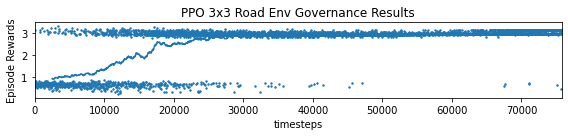

In [17]:
# Helper function from the ploting library.
results_plotter.plot_results([log_dir], 1e5, results_plotter.X_TIMESTEPS, "PPO 3x3 Road Env Governance Results")

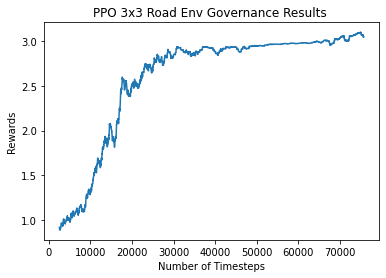

In [18]:
# reward function value curve.
plot_results(log_dir, "PPO 3x3 Road Env Governance Results")

In [ ]:
!cat /tmp/gym/monitor.csv

In [ ]:
env_simple = GreedyGovernanceKernelWrapper(radial=True)
# Logs will be saved in log_dir/monitor.csv
env_simple = Monitor(env_simple, log_dir)
# Training sample environment policy for checking the env functionality.
callback = SaveOnBestTrainingRewardCallback(check_freq=1000, log_dir=log_dir)

ppo_model_3x3_greedy = PPO("MlpPolicy", env_simple, verbose=0)
ppo_model_3x3_greedy.learn(total_timesteps=75000, callback=callback)

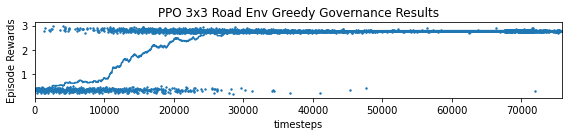

In [21]:
# Helper function from the ploting library.
results_plotter.plot_results([log_dir], 1e5, results_plotter.X_TIMESTEPS, "PPO 3x3 Road Env Greedy Governance Results")

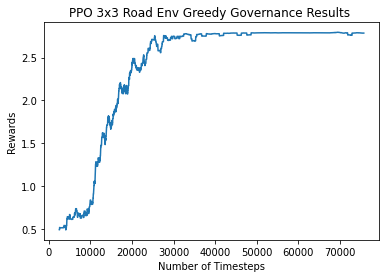

In [22]:
# reward function value curve.
plot_results(log_dir, "PPO 3x3 Road Env Greedy Governance Results")

In [ ]:
!cat /tmp/gym/monitor.csv

In [ ]:
env_random = SimpleGovernanceKernelWrapper(radial=True)
# Logs will be saved in log_dir/monitor.csv
env_random = Monitor(env_random, log_dir)
# Training sample environment policy for checking the env functionality.
callback = SaveOnBestTrainingRewardCallback(check_freq=1000, log_dir=log_dir)

ppo_model_3x3_random = PPO("MlpPolicy", env_random, verbose=0)
ppo_model_3x3_random.learn(total_timesteps=75000, callback=callback)

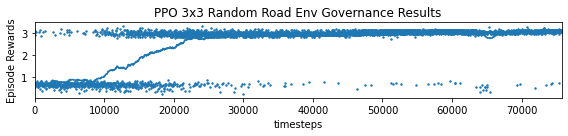

In [27]:
# Helper function from the ploting library.
results_plotter.plot_results([log_dir], 1e5, results_plotter.X_TIMESTEPS, "PPO 3x3 Random Road Env Governance Results")

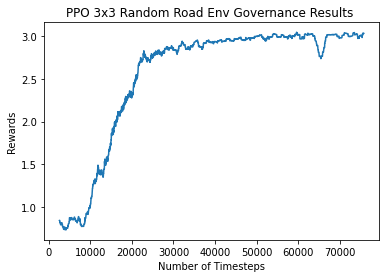

In [28]:
# reward function value curve.
plot_results(log_dir, "PPO 3x3 Random Road Env Governance Results")

In [ ]:
!cat /tmp/gym/monitor.csv

In [ ]:
env_random = GreedyGovernanceKernelWrapper(radial=True)
# Logs will be saved in log_dir/monitor.csv
env_random = Monitor(env_random, log_dir)
# Training sample environment policy for checking the env functionality.
callback = SaveOnBestTrainingRewardCallback(check_freq=1000, log_dir=log_dir)

ppo_model_3x3_random_greedy = PPO("MlpPolicy", env_random, verbose=0)
ppo_model_3x3_random_greedy.learn(total_timesteps=75000, callback=callback)

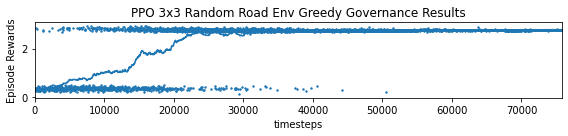

In [36]:
# Helper function from the ploting library.
results_plotter.plot_results([log_dir], 1e5, results_plotter.X_TIMESTEPS, "PPO 3x3 Random Road Env Greedy Governance Results")

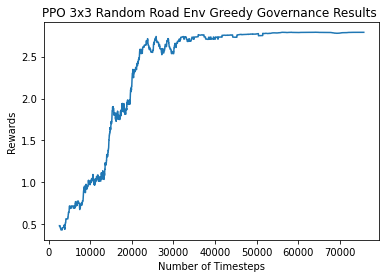

In [37]:
# reward function value curve.
plot_results(log_dir, "PPO 3x3 Random Road Env Greedy Governance Results")

In [ ]:
!cat /tmp/gym/monitor.csv

In [ ]:
env_simple = SimpleGovernanceKernelWrapper()
# Logs will be saved in log_dir/monitor.csv
env_simple = Monitor(env_simple, log_dir)
# Training sample environment policy for checking the env functionality.
callback = SaveOnBestTrainingRewardCallback(check_freq=1000, log_dir=log_dir)

ppo_model_5x5_simple = PPO("MlpPolicy", env_simple, verbose=0)
ppo_model_5x5_simple.learn(total_timesteps=120000, callback=callback)

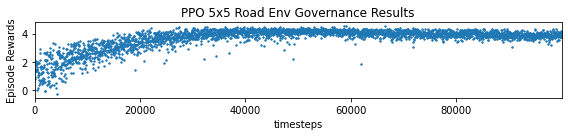

In [13]:
# Helper function from the ploting library.
results_plotter.plot_results([log_dir], 1e5, results_plotter.X_TIMESTEPS, "PPO 5x5 Road Env Governance Results")

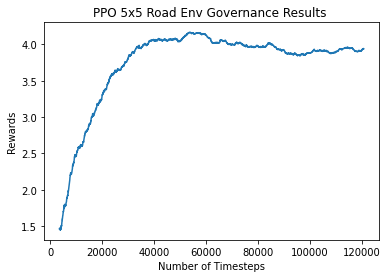

In [14]:
# reward function value curve.
plot_results(log_dir, "PPO 5x5 Road Env Governance Results")

In [ ]:
!cat /tmp/gym/monitor.csv

In [ ]:
env_simple = GreedyGovernanceKernelWrapper()
# Logs will be saved in log_dir/monitor.csv
env_simple = Monitor(env_simple, log_dir)
# Training sample environment policy for checking the env functionality.
callback = SaveOnBestTrainingRewardCallback(check_freq=1000, log_dir=log_dir)

ppo_model_5x5_greedy = PPO("MlpPolicy", env_simple, verbose=0)
ppo_model_5x5_greedy.learn(total_timesteps=120000, callback=callback)

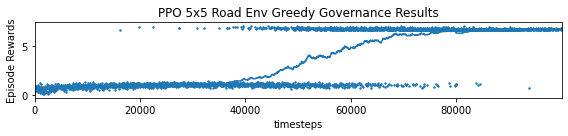

In [66]:
# Helper function from the ploting library.
results_plotter.plot_results([log_dir], 1e5, results_plotter.X_TIMESTEPS, "PPO 5x5 Road Env Greedy Governance Results")

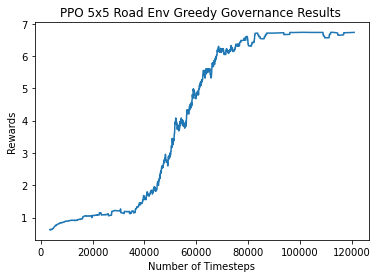

In [67]:
# reward function value curve.
plot_results(log_dir, "PPO 5x5 Road Env Greedy Governance Results")

In [ ]:
!cat /tmp/gym/monitor.csv

In [ ]:
env_random = SimpleGovernanceKernelWrapper()
# Logs will be saved in log_dir/monitor.csv
env_random = Monitor(env_random, log_dir)
# Training sample environment policy for checking the env functionality.
callback = SaveOnBestTrainingRewardCallback(check_freq=1000, log_dir=log_dir)

ppo_model_5x5_random = PPO("MlpPolicy", env_random, verbose=0)
ppo_model_5x5_random.learn(total_timesteps=120000, callback=callback)

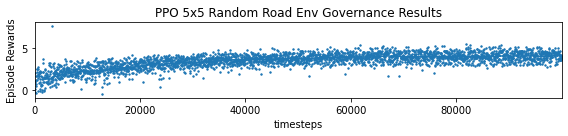

In [71]:
# Helper function from the ploting library.
results_plotter.plot_results([log_dir], 1e5, results_plotter.X_TIMESTEPS, "PPO 5x5 Random Road Env Governance Results")

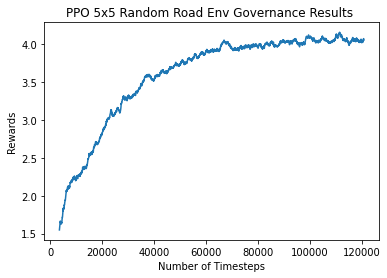

In [72]:
# reward function value curve.
plot_results(log_dir, "PPO 5x5 Random Road Env Governance Results")

In [ ]:
!cat /tmp/gym/monitor.csv

In [ ]:
env_random = GreedyGovernanceKernelWrapper()
# Logs will be saved in log_dir/monitor.csv
env_random = Monitor(env_random, log_dir)
# Training sample environment policy for checking the env functionality.
callback = SaveOnBestTrainingRewardCallback(check_freq=1000, log_dir=log_dir)

ppo_model_5x5_greedy_random = PPO("MlpPolicy", env_random, verbose=0)
ppo_model_5x5_greedy_random.learn(total_timesteps=120000, callback=callback)

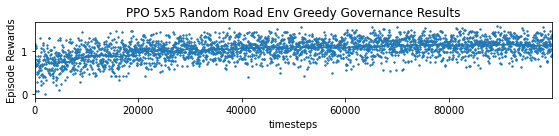

In [75]:
# Helper function from the ploting library.
results_plotter.plot_results([log_dir], 1e5, results_plotter.X_TIMESTEPS, "PPO 5x5 Random Road Env Greedy Governance Results")

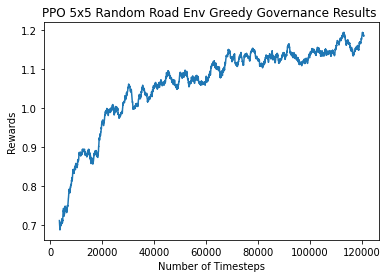

In [76]:
# reward function value curve.
plot_results(log_dir, "PPO 5x5 Random Road Env Greedy Governance Results")

In [ ]:
!cat /tmp/gym/monitor.csv